To visualize the data holistically, we concatenated the DataFrames for the most diverse and least diverse colleges.

In [1]:
import pandas as pd
import ast
from google.colab import drive
drive.mount('/content/drive')

df_most = pd.read_csv('/content/drive/My Drive/most_diverse_colleges.csv')

def string_to_array(des_string):
    try:
        return eval(des_string)
    except (SyntaxError, NameError):
        return []

df_most['Course Descriptions'] = df_most['Course Descriptions'].apply(string_to_array)
df_most['Number of Courses'] = df_most['Course Descriptions'].apply(len)

df_least = pd.read_csv('/content/drive/My Drive/least_diverse_colleges.csv')
df_least['Course Descriptions'] = df_least['Course Descriptions'].apply(ast.literal_eval)
df_least['Number of Courses'] = df_least['Course Descriptions'].apply(len)

df_all = pd.concat([df_most, df_least], ignore_index=True)

Mounted at /content/drive


# Choropleth Map

In order to effectively visualize the SDI values and the number of gender-related courses for each college, we can use a choropleth map to display these data points geographically. To do this, we would need to get the longitude and latitude coordinates for each college (obtained from the National Center for Education Statistics).



In [2]:
df_locs = pd.read_csv('/content/drive/My Drive/college_locations.csv')
df_locs = df_locs.drop(columns=['Unnamed: 4'])
df_locs = df_locs.rename(columns={'Longitude location of institution (HD2023)':'Longitude', 'Latitude location of institution (HD2023)': 'Latitude'})
df_locs.head()

,UnitID,Institution Name,Longitude,Latitude
0,164465,Amherst College,-72.518493,42.372459
1,100858,Auburn University,-85.488258,32.599378
2,217721,Benedict College,-81.020403,34.012941
3,153108,Central College,-92.922199,41.401539
4,190150,Columbia University in the City of New York,-73.961885,40.808286


We then merge these values into the original DataFrame on the column 'UnitID'.

In [3]:
df_all_locs = df_all.merge(df_locs, on='UnitID')
df_all_locs.head()

,UnitID,Name,State,Affiliation,Urbanization,Total,Men total,Women total,American Indian or Alaska Native total,Asian total,...,Hispanic %,Native Hawaiian or Other Pacific Islander %,White %,Two or more races %,SDI,Course Descriptions,Number of Courses,Institution Name,Longitude,Latitude
0,243744,Stanford University,CA,Private not-for-profit (no religious affiliation),21,8054.0,3900.0,4154.0,63.0,2175.0,...,18.5,0.2,23.8,9.3,0.767208,"[Taught by long-time community organizer, Beat...",200,Stanford University,-122.167359,37.429434
1,216287,Swarthmore College,PA,Private not-for-profit (no religious affiliation),21,1644.0,795.0,849.0,7.0,288.0,...,15.1,0.1,29.6,11.0,0.765415,"[ ANTH 044. Gender, Sexuality, and Social Chan...",17,Swarthmore College,-75.354278,39.905159
2,162928,Johns Hopkins University,MD,Private not-for-profit (no religious affiliation),11,6089.0,2742.0,3347.0,9.0,1551.0,...,19.9,0.1,21.8,6.2,0.761917,[This course will serve as an intensive introd...,54,Johns Hopkins University,-76.621595,39.328977
3,182281,University of Nevada-Las Vegas,NV,Public,12,25794.0,11330.0,14464.0,73.0,3997.0,...,35.2,0.8,22.7,14.1,0.761161,[ WMST 427B.) Study of gender and literature t...,65,University of Nevada-Las Vegas,-115.138462,36.106047
4,377564,University of Washington-Tacoma Campus,WA,Public,12,4014.0,2097.0,1917.0,22.0,937.0,...,15.8,1.0,34.3,8.9,0.759269,"[Introduces theories, methods, and analytical ...",23,University of Washington-Tacoma Campus,-122.438541,47.244594


In [5]:
!unzip cb_2023_us_all_20m.zip

Archive:  cb_2023_us_all_20m.zip
 extracting: cb_2023_us_cbsa_20m.zip  
 extracting: cb_2023_us_cd118_20m.zip  
 extracting: cb_2023_us_county_20m.zip  
 extracting: cb_2023_us_csa_20m.zip  
 extracting: cb_2023_us_division_20m.zip  
 extracting: cb_2023_us_metdiv_20m.zip  
 extracting: cb_2023_us_nation_20m.zip  
 extracting: cb_2023_us_region_20m.zip  
 extracting: cb_2023_us_state_20m.zip  


In [6]:
!unzip cb_2023_us_cd118_20m.zip

Archive:  cb_2023_us_cd118_20m.zip
  inflating: cb_2023_us_cd118_20m.shp.ea.iso.xml  
  inflating: cb_2023_us_cd118_20m.shp.iso.xml  
  inflating: cb_2023_us_cd118_20m.shp  
  inflating: cb_2023_us_cd118_20m.shx  
  inflating: cb_2023_us_cd118_20m.dbf  
  inflating: cb_2023_us_cd118_20m.prj  
 extracting: cb_2023_us_cd118_20m.cpg  


In [7]:
import geopandas as gpd
gdf_us = gpd.read_file("cb_2023_us_cd118_20m.shp")

In [8]:
gdf_colleges = gpd.GeoDataFrame(
    df_all_locs,
    geometry=gpd.points_from_xy(
        x=df_all_locs["Longitude"],
        y=df_all_locs["Latitude"]
    ),
    crs=gdf_us.crs
)

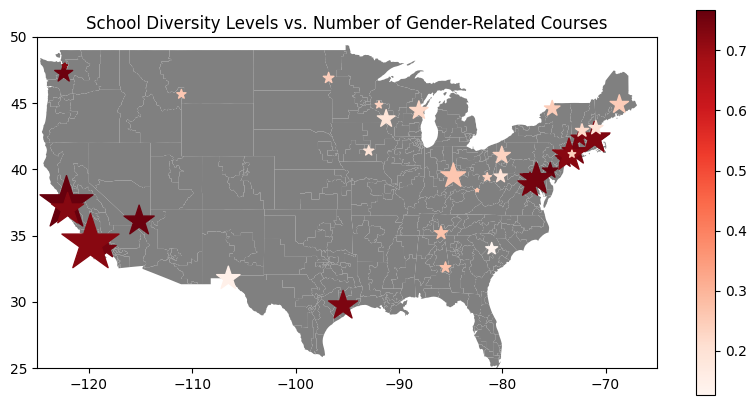

In [29]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf_us.plot(ax=ax, color='gray')
gdf_colleges.plot(ax=ax, column='SDI', cmap='Reds', legend=True, marker="*",
                  markersize=gdf_colleges['Number of Courses'] * 8,
                  figsize=(50, 50), legend_kwds={'shrink': 0.5})

ax.set_title('School Diversity Levels vs. Number of Gender-Related Courses')

ax.set_xlim(-125, -65)
ax.set_ylim(25, 50)

plt.show()

The choropleth map above illustrates the geographic locations of the colleges in our DataFrame. The color intensity of a star reflects the SDI values of each school, with darker red shades indicating a higher level of racial diversity. The size of the star corresponds to the number of gender-related courses offered at each college, with larger stars indicating a greater number of such courses.

It can be observed that there is a trend where more racially diverse schools tend to offer a greater number of gender-related courses. This suggests a potential correlation between SDI and the availability of course offerings at these institutions.

Let's explore the correlation between these two variables:

In [15]:
df_all[['SDI', 'Number of Courses']].corr()

,SDI,Number of Courses
SDI,1.000000,0.456098
Number of Courses,0.456098,1.000000


A correlation value of 0.456 indicates a moderate positive correlation between the two variables: SDI and Number of Courses. This is not too strong nor too weak, so although it suggests that there is some positive association, we cannot conclude that there is a strong correlation between the two variables.

# N-Grams Bar Graphs

Next, we will analyze our textual data: specifically, the course descriptions from the Most and Least Diverse Colleges. By examining the frequency of n-grams (focusing on bigrams), we can gain insights into how certain words and phrases are used across these descriptions.

We will exclude some commonly used 'stop words', such as [and, is, course, class], for analysis purposes.

In [16]:
df_least_diverse = pd.read_csv('/content/drive/My Drive/least_diverse_colleges.csv')
df_most_diverse = pd.read_csv('/content/drive/My Drive/most_diverse_colleges.csv')

In [17]:
!pip install nltk

In [18]:
least_diverse_text = df_least_diverse["Course Descriptions"].sum()
most_diverse_text = df_most_diverse["Course Descriptions"].sum()

In [20]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import plotly.express as px

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

def generate_filtered_ngrams(text):
  stop_words = set(stopwords.words('english'))
  stop_words.update(['course', 'class', 'cross', 'courseblockdesc', 'offered', 'studies', 'selected', 'elective',
                    'students', 'examines', '4b', 'pa'])

  words = word_tokenize(text)

  filtered_words = [word for word in words if word.lower() not in stop_words]

  clean_text = ' '.join(filtered_words)

  vec = CountVectorizer(ngram_range=(2, 2))
  vec.fit([clean_text])
  X = vec.transform([clean_text])
  counts = X.toarray()[0]

  ngrams_df = pd.DataFrame({'ngram': vec.get_feature_names_out(), 'count': counts})

  ngrams_df = ngrams_df.sort_values(by=['count'], ascending=False)

  return ngrams_df

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
filtered_least_ngrams = generate_filtered_ngrams(least_diverse_text)

# Had to manually filter out these ngrams to get relevant ngrams for data analysis
filtered_least_ngrams = filtered_least_ngrams[filtered_least_ngrams['ngram'] != 'pa 4b']
filtered_least_ngrams = filtered_least_ngrams[filtered_least_ngrams['ngram'] != 'cross listed']
filtered_least_ngrams = filtered_least_ngrams[filtered_least_ngrams['ngram'] != 'ic pa']

filtered_least_ngrams = filtered_least_ngrams.head(10)

px.bar(filtered_least_ngrams, x='ngram', y='count', title='Top 10 Bigrams in Least Diverse Colleges')

In [22]:
filtered_most_ngrams = generate_filtered_ngrams(most_diverse_text)

# Had to manually filter out these ngrams to get relevant ngrams for data analysis
filtered_most_ngrams = filtered_most_ngrams[filtered_most_ngrams['ngram'] != 'emphasis seminar']
filtered_most_ngrams = filtered_most_ngrams[filtered_most_ngrams['ngram'] != 'seminar topics']
filtered_most_ngrams = filtered_most_ngrams[filtered_most_ngrams['ngram'] != 'topics include']

filtered_most_ngrams = filtered_most_ngrams.head(10)

px.bar(filtered_most_ngrams, x='ngram', y='count', title='Top 10 Bigrams in Most Diverse Colleges')

It can be observed that the most diverse colleges tend to use more specific and politicized terminology such as “queer” and “human rights”.

# Word Networks

To visualize word usage within the course descriptions, we can create word networks for specific terms. In this network, the central node represents the target word we want to focus on, while the connecting lines to surrounding nodes illustrate the words most commonly used before or after it. This will help us analyze how certain words are used and how their usage differs between the most and least diverse colleges.

In [32]:
from collections import defaultdict
import networkx as nx

def create_word_network(text, target_word, category):
    stop_words = set(stopwords.words('english'))
    stop_words.add('course')

    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word.isalnum()]

    word_connections = defaultdict(int)

    for i in range(len(filtered_words) - 1):
        if filtered_words[i] == target_word:
            word_connections[filtered_words[i + 1]] += 1
        if filtered_words[i + 1] == target_word:
            word_connections[filtered_words[i]] += 1

    related_words = sorted(word_connections, key=word_connections.get, reverse=True)[:10]
    all_network_words = [target_word] + related_words

    G = nx.Graph()
    G.add_nodes_from(all_network_words)

    for i in range(len(filtered_words) - 1):
        if filtered_words[i] in all_network_words and filtered_words[i + 1] in all_network_words:
            G.add_edge(filtered_words[i], filtered_words[i + 1])

    node_colors = ['red' if node == target_word else 'lightblue' for node in G.nodes()]

    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.6, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", font_color="black")
    plt.title(f"{category} Word Network for '{target_word}'", fontsize=14)
    plt.axis("off")
    plt.show()

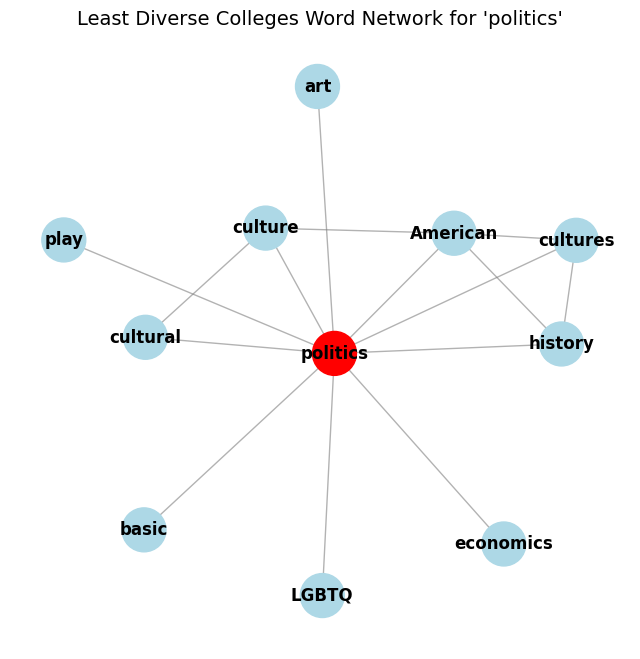

In [34]:
least_diverse_text = ' '.join(df_least['Course Descriptions'].astype(str).tolist())
create_word_network(least_diverse_text, 'politics', 'Least Diverse Colleges')

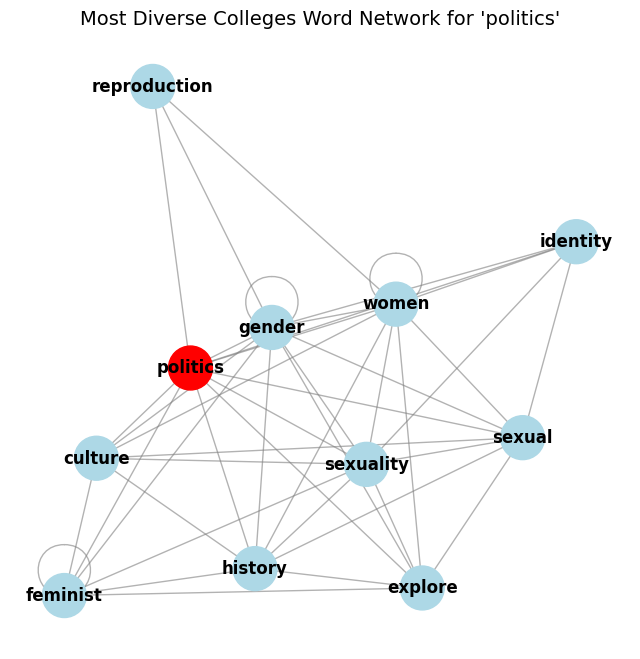

In [33]:
most_diverse_text = ' '.join(df_most['Course Descriptions'].astype(str).tolist())
create_word_network(most_diverse_text, 'politics', 'Most Diverse Colleges')

The word network for the central node 'politics' reveals distinct differences between the Least and Most Diverse Colleges. For the Least Diverse Colleges, political topics are primarily connected to terms such as 'culture', 'history', and 'economics'.

In contrast, the word network for 'politics' in the Most Diverse Colleges connect this term to 'gender', 'sexuality', and 'feminist', indicating a focus on political issues through a gender and identity-focused lens.

The difference between the two word networks suggests that courses in the Most Diverse Colleges are more likely to address political topics within the context of gender-related studies, while Least Diverse Colleges take a more general approach.